In [1]:
import torch
torch.cuda.is_available()

torch.cuda.device_count()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cuda



In [2]:
pip install torchnet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 5.3 MB/s eta 0:00:00a 0:00:010m
  Preparing metadata (setup.py) ... done
  Created wheel for torchnet: filename=torchnet-0.0.4-py3-none-any.whl size=29742 sha256=6f1573a8a9f55fe9ca6bc2b172cfb35ab206165b5e2de5303a01f324ec94fd78
  Stored in directory: /root/.cache/pip/wheels/93/17/b3/86db1d93e9dae198813aa79831b403e4844d67986cf93894b5
  Created wheel for visdom: filename=visdom-0.2.3-py3-none-any.whl size=1417108 sha256=9f616022cecc0f03cbe2594bd220bbfecce9aec45774c4bc9ef4c9ea722d8f41
  Stored in directory: /root/.cache/pip/wheels/6c/cc/34/0a5e6c65ecd5efecaebb4e9a913d438643dbc50e739d1662ca
Successfully built torchnet visdom
Note: you may need to restart the kernel to use updated packages.


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import seaborn as sn
import pandas as pd
import torchnet.meter.confusionmeter as cm

In [6]:
import os
print(os.listdir('/kaggle/input'))
print(os.listdir('/kaggle/input/hagrid384pbalanced'))

['hagrid384pbalanced']
['hagrid_split']


In [7]:
# Data augmentation and normalization for training
# Just normalization for validation & test
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [9]:
data_dir = '/kaggle/input/hagrid384pbalanced/hagrid_split'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [10]:
#lists for graph generation
epoch_counter_train = []
epoch_counter_val = []
train_loss = []
val_loss = []
train_acc = []
val_acc = []

In [11]:
#Train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch +1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            #For graph generation
            if phase == "train":
                train_loss.append(running_loss/dataset_sizes[phase])
                train_acc.append(running_corrects.double() / dataset_sizes[phase])
                epoch_counter_train.append(epoch)
            if phase == "val":
                val_loss.append(running_loss/ dataset_sizes[phase])
                val_acc.append(running_corrects.double() / dataset_sizes[phase])
                epoch_counter_val.append(epoch)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            #for printing        
            if phase == "train":    
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == "val":    
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [12]:
#MobileNet V3 small
mobmodel = torchvision.models.mobilenet_v3_small(pretrained=True)
#model.eval()

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


  0%|          | 0.00/9.83M [00:00<?, ?B/s]

In [13]:
num_ftrs = mobmodel.classifier[3].in_features
mobmodel.classifier[3] = nn.Linear(num_ftrs, 8)

In [14]:
mobmodel= mobmodel.to(device)
criterion = nn.CrossEntropyLoss()

In [18]:
# Using Adam as the parameter optimizer
optimizer_ft = optim.Adam(mobmodel.parameters(), lr = 0.001, betas=(0.9, 0.999))

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [19]:
mobmodel = train_model(mobmodel, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)   

Epoch 1/10
----------
train Loss: 0.9658 Acc: 0.6514
val Loss: 0.5203 Acc: 0.8214

Epoch 2/10
----------
train Loss: 0.8907 Acc: 0.6747
val Loss: 0.4799 Acc: 0.8247

Epoch 3/10
----------
train Loss: 0.8379 Acc: 0.6914
val Loss: 0.3950 Acc: 0.8649

Epoch 4/10
----------
train Loss: 0.8233 Acc: 0.6976
val Loss: 0.3757 Acc: 0.8700

Epoch 5/10
----------
train Loss: 0.7867 Acc: 0.7125
val Loss: 0.3735 Acc: 0.8710

Epoch 6/10
----------
train Loss: 0.7653 Acc: 0.7152
val Loss: 0.3948 Acc: 0.8621

Epoch 7/10
----------
train Loss: 0.6769 Acc: 0.7437
val Loss: 0.2627 Acc: 0.9088

Epoch 8/10
----------
train Loss: 0.6496 Acc: 0.7519
val Loss: 0.2433 Acc: 0.9123

Epoch 9/10
----------
train Loss: 0.6286 Acc: 0.7633
val Loss: 0.2346 Acc: 0.9144

Epoch 10/10
----------
train Loss: 0.6185 Acc: 0.7644
val Loss: 0.2288 Acc: 0.9188

Training complete in 33m 20s
Best val Acc: 0.918750


In [20]:
#Test the accuracy with test data
correct = 0
total = 0
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = mobmodel(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 91 %


In [31]:
from sklearn.metrics import f1_score
# Iterate over data.
y_true, y_pred = [], []
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        #outputs = model(inputs)
        predicted_outputs = mobmodel(inputs)
        _, predicted = torch.max(predicted_outputs, 1)
        total += labels.size(0)
        #print(total)
        correct += (predicted == labels).sum().item()
        #print(correct)
        #f1 score
        temp_true=labels.cpu().data.numpy()
        temp_pred=predicted.cpu().data.numpy()
        y_true+=temp_true.tolist()
        y_pred+=temp_pred.tolist()
        
print('F1 Score:')
f1=f1_score(y_true,y_pred, average = 'macro')
print(f1)

F1 Score:
0.9184958190519207


In [32]:
#Class wise testing accuracy
class_correct = list(0. for i in range(8))
class_total = list(0. for i in range(8))
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = mobmodel(inputs)
            _, predicted = torch.max(outputs, 1)
            point = (predicted == labels).squeeze()
            for j in range(len(labels)):
                label = labels[j]
                class_correct[label] += point[j].item()
                class_total[label] += 1

for i in range(8):
    print('Accuracy of %5s : %2d %%' % (
        class_names[i], 100 * class_correct[i] / class_total[i]))

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fdd31e53830>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7fdd31e53830>if w.is_alive():

  File "/opt/conda/lib/python3.7/multiprocessing/process.py", lin

Accuracy of  call : 92 %
Accuracy of dislike : 96 %
Accuracy of  fist : 91 %
Accuracy of  like : 92 %
Accuracy of    ok : 89 %
Accuracy of  palm : 88 %
Accuracy of  rock : 91 %
Accuracy of  stop : 92 %


In [34]:
#Get the confusion matrix for testing data
confusion_matrix = cm.ConfusionMeter(8)
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = mobmodel(inputs)
        _, predicted = torch.max(outputs, 1)
        confusion_matrix.add(predicted, labels)
    print(confusion_matrix.conf)


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fdd31e53830>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fdd31e53830><function _MultiProcessingDataLoaderIter.__del__ at 0x7fdd31e53830>Traceback (most recent call last):


Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()Exception ignored in: 
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    if w.is_alive():    Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fdd31e53830>self._shutdown_workers()  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__



Traceback (most recent call last):
  F

[[928  12   6  38   9   0   4   3]
 [ 15 962   6  10   3   2   1   1]
 [  5   5 912   9  21   5  22  21]
 [ 32  17  13 922   8   5   2   1]
 [  6   5  13  13 898  23  25  17]
 [  3   3   6   4  45 888  10  41]
 [  4   4  24   2  20  10 912  24]
 [  1   0  14   3  12  26  18 926]]


<AxesSubplot:>

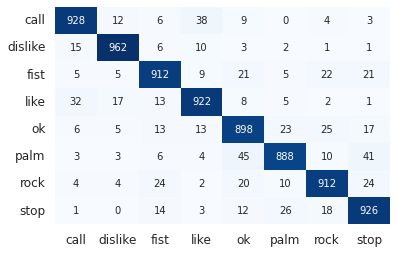

In [35]:
#Confusion_matrix as a heatmap
con_m = confusion_matrix.conf
df_con_m = pd.DataFrame(con_m, index= [i for i in class_names], columns = [i for i in class_names])
sn.set(font_scale= 1.1)
sn.heatmap(df_con_m, annot=True,fmt='g' ,  annot_kws={"size" : 10}, cbar = False, cmap="Blues") 

In [37]:
mobilenet_path='/kaggle/working/mobilenet.pth'
torch.save(mobmodel.state_dict(), mobilenet_path)
mobmodel.load_state_dict(torch.load(mobilenet_path))

<All keys matched successfully>

In [38]:
#Googlenet
gmodel = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [39]:
num_ftrs = gmodel.fc.in_features
gmodel.fc = nn.Linear(num_ftrs, 8)

In [40]:
gmodel= gmodel.to(device)
criterion = nn.CrossEntropyLoss()

In [41]:
# Using Adam as the parameter optimizer
optimizer_ft = optim.Adam(gmodel.parameters(), lr = 0.001, betas=(0.9, 0.999))

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [42]:
gmodel = train_model(gmodel, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)  

Epoch 1/10
----------


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


train Loss: 1.1480 Acc: 0.5872
val Loss: 0.3641 Acc: 0.8826

Epoch 2/10
----------
train Loss: 0.9041 Acc: 0.6725
val Loss: 0.5853 Acc: 0.8145

Epoch 3/10
----------
train Loss: 0.8058 Acc: 0.7055
val Loss: 0.3284 Acc: 0.8960

Epoch 4/10
----------
train Loss: 0.7573 Acc: 0.7192
val Loss: 0.2448 Acc: 0.9234

Epoch 5/10
----------
train Loss: 0.7476 Acc: 0.7241
val Loss: 0.2263 Acc: 0.9281

Epoch 6/10
----------
train Loss: 0.7168 Acc: 0.7342
val Loss: 0.2117 Acc: 0.9344

Epoch 7/10
----------
train Loss: 0.6088 Acc: 0.7712
val Loss: 0.1374 Acc: 0.9581

Epoch 8/10
----------
train Loss: 0.5769 Acc: 0.7794
val Loss: 0.1229 Acc: 0.9615

Epoch 9/10
----------
train Loss: 0.5660 Acc: 0.7856
val Loss: 0.1153 Acc: 0.9631

Epoch 10/10
----------
train Loss: 0.5479 Acc: 0.7910
val Loss: 0.1116 Acc: 0.9637

Training complete in 35m 2s
Best val Acc: 0.963750


In [43]:
#Test the accuracy with test data
correct = 0
total = 0
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = gmodel(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 96 %


In [44]:
#Class wise testing accuracy
class_correct = list(0. for i in range(8))
class_total = list(0. for i in range(8))
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = gmodel(inputs)
            _, predicted = torch.max(outputs, 1)
            point = (predicted == labels).squeeze()
            for j in range(len(labels)):
                label = labels[j]
                class_correct[label] += point[j].item()
                class_total[label] += 1

for i in range(8):
    print('Accuracy of %5s : %2d %%' % (
        class_names[i], 100 * class_correct[i] / class_total[i]))

Accuracy of  call : 96 %
Accuracy of dislike : 98 %
Accuracy of  fist : 95 %
Accuracy of  like : 96 %
Accuracy of    ok : 96 %
Accuracy of  palm : 95 %
Accuracy of  rock : 96 %
Accuracy of  stop : 96 %


In [45]:
from sklearn.metrics import f1_score
# Iterate over data.
y_true, y_pred = [], []
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        #outputs = model(inputs)
        predicted_outputs = gmodel(inputs)
        _, predicted = torch.max(predicted_outputs, 1)
        total += labels.size(0)
        #print(total)
        correct += (predicted == labels).sum().item()
        #print(correct)
        #f1 score
        temp_true=labels.cpu().data.numpy()
        temp_pred=predicted.cpu().data.numpy()
        y_true+=temp_true.tolist()
        y_pred+=temp_pred.tolist()
        
print('F1 Score:')
f1=f1_score(y_true,y_pred, average = 'macro')
print(f1)

F1 Score:
0.9643893186074199


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


[[969   9   2  19   0   0   1   0]
 [  6 983   1   7   2   0   1   0]
 [  3   4 953   4  11   2  13  10]
 [ 18  10   3 962   1   0   4   2]
 [  2   3   3  11 963   6  10   2]
 [  1   2   0   4  21 953   6  13]
 [  1   3   5   3  15   3 965   5]
 [  0   1   5   6   4  12   5 967]]


<AxesSubplot:>

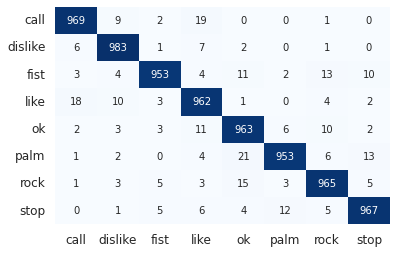

In [46]:
#Get the confusion matrix for testing data
confusion_matrix = cm.ConfusionMeter(8)
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = gmodel(inputs)
        _, predicted = torch.max(outputs, 1)
        confusion_matrix.add(predicted, labels)
    print(confusion_matrix.conf)

#Confusion_matrix as a heatmap
con_m = confusion_matrix.conf
df_con_m = pd.DataFrame(con_m, index= [i for i in class_names], columns = [i for i in class_names])
sn.set(font_scale= 1.1)
sn.heatmap(df_con_m, annot=True,fmt='g' ,  annot_kws={"size" : 10}, cbar = False, cmap="Blues") 

In [47]:
googlenet_path='/kaggle/working/googlenet.pth'
torch.save(gmodel.state_dict(), googlenet_path)
gmodel.load_state_dict(torch.load(googlenet_path))

<All keys matched successfully>

In [48]:
#For resnet18
resmodel = models.resnet18(pretrained=True)
num_ftrs = resmodel.fc.in_features
resmodel.fc = nn.Linear(num_ftrs, 8)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [49]:
resmodel = resmodel.to(device)

criterion = nn.CrossEntropyLoss()

In [50]:
# Using Adam as the parameter optimizer
optimizer_ft = optim.Adam(resmodel.parameters(), lr = 0.001, betas=(0.9, 0.999))

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [51]:
resmodel = train_model(resmodel, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)    

Epoch 1/10
----------
train Loss: 1.4649 Acc: 0.4574
val Loss: 0.8089 Acc: 0.7364

Epoch 2/10
----------
train Loss: 1.0218 Acc: 0.6348
val Loss: 0.4106 Acc: 0.8725

Epoch 3/10
----------
train Loss: 0.8933 Acc: 0.6774
val Loss: 0.3509 Acc: 0.8881

Epoch 4/10
----------
train Loss: 0.8346 Acc: 0.6965
val Loss: 0.3786 Acc: 0.8794

Epoch 5/10
----------
train Loss: 0.7831 Acc: 0.7122
val Loss: 0.3626 Acc: 0.8890

Epoch 6/10
----------
train Loss: 0.7451 Acc: 0.7278
val Loss: 0.3043 Acc: 0.9025

Epoch 7/10
----------
train Loss: 0.6504 Acc: 0.7547
val Loss: 0.1738 Acc: 0.9441

Epoch 8/10
----------
train Loss: 0.6054 Acc: 0.7711
val Loss: 0.1499 Acc: 0.9545

Epoch 9/10
----------
train Loss: 0.5860 Acc: 0.7753
val Loss: 0.1477 Acc: 0.9537

Epoch 10/10
----------
train Loss: 0.5789 Acc: 0.7788
val Loss: 0.1314 Acc: 0.9574

Training complete in 30m 11s
Best val Acc: 0.957375


In [52]:
#Test the accuracy with test data
correct = 0
total = 0
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = resmodel(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 95 %


In [53]:
#Class wise testing accuracy
class_correct = list(0. for i in range(8))
class_total = list(0. for i in range(8))
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = resmodel(inputs)
            _, predicted = torch.max(outputs, 1)
            point = (predicted == labels).squeeze()
            for j in range(len(labels)):
                label = labels[j]
                class_correct[label] += point[j].item()
                class_total[label] += 1

for i in range(8):
    print('Accuracy of %5s : %2d %%' % (
        class_names[i], 100 * class_correct[i] / class_total[i]))

Accuracy of  call : 95 %
Accuracy of dislike : 98 %
Accuracy of  fist : 96 %
Accuracy of  like : 94 %
Accuracy of    ok : 95 %
Accuracy of  palm : 92 %
Accuracy of  rock : 96 %
Accuracy of  stop : 96 %


In [54]:
from sklearn.metrics import f1_score
# Iterate over data.
y_true, y_pred = [], []
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        #outputs = model(inputs)
        predicted_outputs = resmodel(inputs)
        _, predicted = torch.max(predicted_outputs, 1)
        total += labels.size(0)
        #print(total)
        correct += (predicted == labels).sum().item()
        #print(correct)
        #f1 score
        temp_true=labels.cpu().data.numpy()
        temp_pred=predicted.cpu().data.numpy()
        y_true+=temp_true.tolist()
        y_pred+=temp_pred.tolist()
        
print('F1 Score:')
f1=f1_score(y_true,y_pred, average = 'macro')
print(f1)

F1 Score:
0.9569890308159049


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[[955   9   5  24   2   1   4   0]
 [  6 980   2   9   2   0   0   1]
 [  1   8 966   2   2   2  15   4]
 [ 28  14   3 944   4   1   5   1]
 [  4   6   8   9 957   4   6   6]
 [  1   8   4   5  30 928   5  19]
 [  2   6  13   2  13   1 962   1]
 [  2   2   5   3   9   5  10 964]]


<AxesSubplot:>

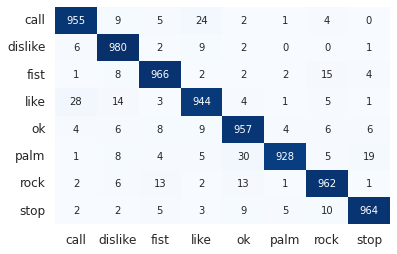

In [55]:
#Get the confusion matrix for testing data
confusion_matrix = cm.ConfusionMeter(8)
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = resmodel(inputs)
        _, predicted = torch.max(outputs, 1)
        confusion_matrix.add(predicted, labels)
    print(confusion_matrix.conf)

#Confusion matrix as a heatmap
con_m = confusion_matrix.conf
df_con_m = pd.DataFrame(con_m, index= [i for i in class_names], columns = [i for i in class_names])
sn.set(font_scale= 1.1)
sn.heatmap(df_con_m, annot=True,fmt='g' ,  annot_kws={"size" : 10}, cbar = False, cmap="Blues") 


In [56]:
resnet_path='/kaggle/working/resnet.pth'
torch.save(resmodel.state_dict(), resnet_path)
resmodel.load_state_dict(torch.load(resnet_path))

<All keys matched successfully>